<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/producedwatertreatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Simulation of produced water treatment
#@markdown Introduction to process simualtion of produced water treatment
%%capture
!pip install neqsim
from neqsim.process import openprocess
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#Litterature

https://vmecompanies.com/produced-water-treatment/

https://www.filtsep.com/water-and-wastewater/features/oil-and-gas-water-treatment-in-oil-and-gas/

https://www.filtsep.com/water-and-wastewater/features/oil-and-gas-treatment-and-discharge-of-produced/

http://folk.ntnu.no/skoge/diplom/diplom08/pettersen_tone/Diplom_Tone.pdf


#Water purification treatment 

#Oil-water separation
Oil and water separation offshore can be divided into three stages: A rough separation of oil,
gas and water provided by the separator, further removal of water from the produced oil and
oil removal from water ahead of discharge back into the ocean or injection into a reservoir.
The latter one is of highest interest wanting to minimize the environmental impact, and is
provided a further discussion in the following section. 

#Equipment
##Gravity Separators
Provides separation based on the specific gravity difference between the oil and the wastewater, and separation efficiency depends highly on the residence time of the dispersed fluid in the tank. The tank has its greatest efficiency in
removing bigger amounts of oil, and can not be the only measure in a water cleaning
system fulfilling governmental restrictions.
##Oil skimmer
Separates oil floating on water.
##Plate coalescer
Uses plates to capture the oil drops, which glides of as a film.
##Flotation tanks/cells
Uses dissolved air flotation dissolving air in the waste water
under pressure and then releasing the air at atmospheric pressure in the flotation tank. The released air forms tiny bubbles which adhere to the suspended matter causing it to float to the surface of the water where it is removed by a skimming device. The measure makes removing very small droplets possible.
##Hydro cyclones
The most important measure used in the industry today.


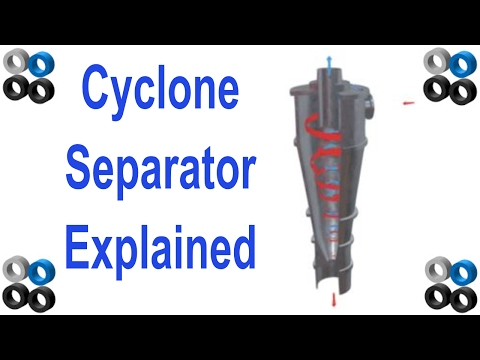

In [2]:
#@title How Cyclone Separator Works
#@markdown This video explains what a cyclone separator is, how it functions, its advantages over filters and its typical applications. 
from IPython.display import YouTubeVideo
YouTubeVideo('tvVj6fx6MNI', width=600, height=400)

#Hydrocyclones
Hydrocyclone based process systems are cost-effective solution for produced water treatment clean up. Located directly downstream on the water outlet of the production separator and upstream of the water level control valve, these systems operate in a proportional “pressure ratio” control manner.

By controlling the pressure differential across the hydrocyclone the water phase is sent in one direction to the underflow, and the oil phase is sent in the opposite direction to the overflow.  The process results in a simple and effective separator with a 2-3 second retention time and no moving parts.

#Simulation of produced water treatment using NeqSim
The CPA-EoS in NeqSim is well suted for calculating solubilities of oil in water and water in oil for a varity of reservoir fluids and process conditions.
In the following example we will simulate a typical topside separation and water treatment process using NeqSim.

#1. Defining the well stream

In [3]:
# Create a gas-condensate fluid
gascondensate = {'ComponentName':  ['water', "nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20"], 
        'MolarComposition[-]':  [0.0, 0.53, 8.3, 70.98, 5.68, 3.1, 0.7, 1.42, 0.54, 0.67, 0.85, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8], 
        'MolarMass[kg/mol]': [None, None,None, None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391],
        'RelativeDensity[-]': [None, None,None, None,None,None,None,None,None,None,None, 0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877]
  } 

gascondensatedf = pd.DataFrame(gascondensate) 
print("Gas Condensate Fluid:\n")
print(gascondensatedf.head(30).to_string())
gascondensateFluid = fluid_df(gascondensatedf, lastIsPlusFraction=False).autoSelectModel()

Gas Condensate Fluid:

   ComponentName  MolarComposition[-]  MolarMass[kg/mol]  RelativeDensity[-]
0          water                 0.00                NaN                 NaN
1       nitrogen                 0.53                NaN                 NaN
2            CO2                 8.30                NaN                 NaN
3        methane                70.98                NaN                 NaN
4         ethane                 5.68                NaN                 NaN
5        propane                 3.10                NaN                 NaN
6       i-butane                 0.70                NaN                 NaN
7       n-butane                 1.42                NaN                 NaN
8      i-pentane                 0.54                NaN                 NaN
9      n-pentane                 0.67                NaN                 NaN
10      n-hexane                 0.85                NaN                 NaN
11            C7                 1.33             0.0

#2. Defining the water stream



In [4]:
# Create a pure water fluid
waterFluid = gascondensateFluid.clone()
watercomoposition= [0.0] * len(gascondensate['ComponentName'])
watercomoposition[0] = 1.0
fluidComposition(waterFluid, watercomoposition)


#2. Creating the separation process

In [5]:
from neqsim.thermo import fluid
from neqsim.process import clearProcess, stream, valve, runProcess, viewProcess, mixer, recycle,separator3phase, separator


clearProcess()
reservoirFluidStream = stream(gascondensateFluid)
reservoirFluidStream.setFlowRate(5.3, 'MSm3/day')
reservoirFluidStream.setPressure(85.2, 'bara')
reservoirFluidStream.setTemperature(95.1, 'C')

waterStream = stream(waterFluid)
waterStream.setFlowRate(1090500.0, 'kg/day')
waterStream.setPressure(85.2, 'bara')
waterStream.setTemperature(95.1, 'C')

feedMixer = mixer()
feedMixer.addStream(reservoirFluidStream)
feedMixer.addStream(waterStream)

inletSeparator = separator3phase(feedMixer.getOutStream(), "1st stage separator")

waterDpValve = valve(inletSeparator.getWaterOutStream(), 3.31325, 'water depressurising valve')

waterDegasingDrum = separator(waterDpValve.getOutStream(), "water degassing drum")

gasToFlare = waterDegasingDrum.getGasOutStream()

waterToSea = waterDegasingDrum.getLiquidOutStream()

runProcess()
feedMixer.run()
print('gas to flare ', gasToFlare.getFlowRate('Sm3/hr'), ' Sm3/hr')
print('composition of gas to flare:')
printFrame(gasToFlare.getFluid())
print()
print('water to sea ', waterToSea.getFlowRate('kg/hr'), ' kg/hr')
print('composition of water to sea:')
printFrame(waterToSea.getFluid())
oiw = (1.0-waterToSea.getFluid().getComponent('water').getz()-waterToSea.getFluid().getComponent('CO2').getz())*1.0e6
print('oil in water', oiw, ' ppm mole')
print('gas gas perm3 water from degasser : ', gasToFlare.getFlowRate('kg/hr')/(waterToSea.getFlowRate('kg/hr')/1000.0), ' kg/m3 water')

gas to flare  131.41244879422808  Sm3/hr
composition of gas to flare:
                           total                   gas                       
              water   2.36782E-1            2.36782E-1        [mole fraction]
           nitrogen   1.66155E-3            1.66155E-3        [mole fraction]
                CO2   3.51027E-1            3.51027E-1        [mole fraction]
            methane   3.54162E-1            3.54162E-1        [mole fraction]
             ethane   4.52651E-2            4.52651E-2        [mole fraction]
            propane    6.9898E-3             6.9898E-3        [mole fraction]
           i-butane   1.30443E-3            1.30443E-3        [mole fraction]
           n-butane   1.76886E-3            1.76886E-3        [mole fraction]
          i-pentane   1.54959E-4            1.54959E-4        [mole fraction]
          n-pentane   2.50268E-4            2.50268E-4        [mole fraction]
           n-hexane   1.30315E-4            1.30315E-4        [mole frac

# Aromatic compounds in produced water
This example demonstrates of aromatic components are distributed in a water phase at various pressures.

In [15]:
# Create a gas-condensate fluid
gascondensate = {'ComponentName':  ['water', "nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane","benzene", "toluene", "m-Xylene", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20"], 
        'MolarComposition[-]':  [21.0, 0.53, 8.3, 70.98, 5.68, 3.1, 0.7, 1.42, 0.54, 0.67, 0.85, 0.1, 0.1, 0.1, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8], 
        'MolarMass[kg/mol]': [None, None,None, None,None,None,None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391],
        'RelativeDensity[-]': [None, None,None, None,None,None,None,None,None,None,None, None,None,None,0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877]
  } 

gascondensatedf = pd.DataFrame(gascondensate) 
print("Gas Condensate Fluid:\n")
print(gascondensatedf.head(30).to_string())
gascondensateFluid = fluid_df(gascondensatedf, lastIsPlusFraction=False).autoSelectModel()

Gas Condensate Fluid:

   ComponentName  MolarComposition[-]  MolarMass[kg/mol]  RelativeDensity[-]
0          water                21.00                NaN                 NaN
1       nitrogen                 0.53                NaN                 NaN
2            CO2                 8.30                NaN                 NaN
3        methane                70.98                NaN                 NaN
4         ethane                 5.68                NaN                 NaN
5        propane                 3.10                NaN                 NaN
6       i-butane                 0.70                NaN                 NaN
7       n-butane                 1.42                NaN                 NaN
8      i-pentane                 0.54                NaN                 NaN
9      n-pentane                 0.67                NaN                 NaN
10      n-hexane                 0.85                NaN                 NaN
11       benzene                 0.10                

In [81]:
clearProcess()
reservoirFluidStream = stream(gascondensateFluid)
reservoirFluidStream.setFlowRate(1.3, 'MSm3/day')
reservoirFluidStream.setPressure(35.2, 'bara')
reservoirFluidStream.setTemperature(60.1, 'C')

inletSeparator = separator3phase(reservoirFluidStream, "1st stage separator")

waterDpValve = valve(inletSeparator.getWaterOutStream(), 3.31325, 'water depressurising valve')

waterDegasingDrum = separator(waterDpValve.getOutStream(), "water degassing drum")

gasToFlare = waterDegasingDrum.getGasOutStream()
runProcess()

print("reservoir fluid:\n")
printFrame(reservoirFluidStream.getFluid())

reservoir fluid:

                          total                   gas                   oil               aqueous                   
              water   1.7311E-1            6.27235E-3            2.47469E-3             9.9877E-1    [mole fraction]
           nitrogen  4.36897E-3            5.89242E-3            2.82432E-4            1.72714E-6    [mole fraction]
                CO2  6.84198E-2            8.93565E-2             2.5954E-2            7.04317E-4    [mole fraction]
            methane  5.85113E-1            7.80716E-1            1.03009E-1            4.46934E-4    [mole fraction]
             ethane  4.68222E-2            5.95479E-2            3.09884E-2            5.66989E-5    [mole fraction]
            propane  2.55544E-2            2.91488E-2            4.30357E-2            8.18758E-6    [mole fraction]
           i-butane  5.77034E-3            5.72055E-3            1.64227E-2            1.81945E-6    [mole fraction]
           n-butane  1.17055E-2            1.0

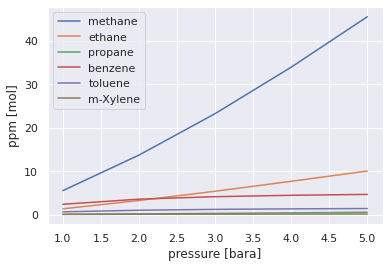

In [82]:
pressures = range(1, 6, 1)
ppmMethane = []
ppmEthane = []
ppmPropane = []
ppmBenzne = []
ppmToluene=[]
ppmXylene = []
for pres in pressures:
  waterDpValve.setOutletPressure(float(pres))
  runProcess()
  ppmMethane.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('methane').getz()*1e6)
  ppmEthane.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('ethane').getz()*1e6)
  ppmPropane.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('propane').getz()*1e6)
  ppmBenzne.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('benzene').getz()*1e6)
  ppmToluene.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('toluene').getz()*1e6)
  ppmXylene.append(waterDegasingDrum.getLiquidOutStream().getFluid().getComponent('m-Xylene').getz()*1e6)
  #print('benzene ', ppmBenzne, ' ppmToluene ',ppmToluene, ' ppmXylene ',ppmXylene, " ppm(mol)")

plt.plot(pressures, ppmMethane)
plt.plot(pressures, ppmEthane)
plt.plot(pressures, ppmPropane)
plt.plot(pressures, ppmBenzne)
plt.plot(pressures, ppmToluene)
plt.plot(pressures, ppmXylene)
plt.legend(['methane', 'ethane', 'propane', 'benzene', 'toluene', 'm-Xylene'], loc='upper left')
plt.xlabel('pressure [bara]')
plt.ylabel('ppm [mol]')
plt.show()

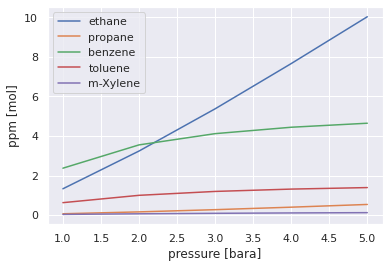

In [83]:
plt.plot(pressures, ppmEthane)
plt.plot(pressures, ppmPropane)
plt.plot(pressures, ppmBenzne)
plt.plot(pressures, ppmToluene)
plt.plot(pressures, ppmXylene)
plt.legend(['ethane', 'propane', 'benzene', 'toluene', 'm-Xylene'], loc='upper left')
plt.xlabel('pressure [bara]')
plt.ylabel('ppm [mol]')
plt.show()